In [26]:
from quspin.operators import hamiltonian# operators
from quspin.basis import boson_basis_1d # Hilbert space boson basis
from quspin.basis import tensor_basis,spinless_fermion_basis_1d # Hilbert spaces
from quspin.basis import spin_basis_1d # Hilbert space spin basis
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function, division
from quspin.tools.measurements import obs_vs_time # t_dep measurements
from quspin.tools.Floquet import Floquet_t_vec
from quspin.tools.evolution import evolve # ODE evolve tool

### Build basis and Hamiltonian

In [141]:
from quspin.operators import hamiltonian# operators
from quspin.basis import boson_basis_1d # Hilbert space boson basis
from quspin.basis import tensor_basis,spinless_fermion_basis_1d # Hilbert spaces
from quspin.basis import spin_basis_1d # Hilbert space spin basis
Nsites = 6
Nbosons = 6
###### parameters
L_spin = Nsites-1
L_modes = Nsites # system size
cutoff = Nbosons+1 #sites+2
h = 1 # field strength
t = 1
###### create the basis
# building the two bases to tensor together
basis_spin = spin_basis_1d(L=L_spin)
basis_boson=boson_basis_1d(L=L_modes,sps=cutoff)
basis = tensor_basis(basis_spin,basis_boson)
# print(basis)

##### create model


### define initial state

In [142]:
from qutip import *
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import eigsh
from quspin.operators import hamiltonian# operators
from quspin.basis import boson_basis_1d # Hilbert space boson basis
from quspin.basis import tensor_basis,spinless_fermion_basis_1d # Hilbert spaces
from quspin.basis import spin_basis_1d # Hilbert space spin basis
def flip(s):
    if s == '+':
        return '-'
    elif s == '-':
        return '+'

def isodd(n):
    return int(n)%2 == True

def binom(n, k):
    return np.math.factorial(n) // np.math.factorial(k) // np.math.factorial(n - k)

def gaugeFixedBasis(Nsites,Nbosons):
    bosonStates = []
    gaugefixedStates = []
    # Let's first list out all possible boson occupations.
    # We can do this by looping through all numbers and putting it into base Nbosons
    for number in np.arange((Nbosons+1)**Nsites):
        bosonString = np.base_repr(number, base=Nbosons+1)
        # print(bosonString)
        bosonString = '0' * (Nsites - len(bosonString)) + bosonString

        # check total boson number
        if sum([int(c) for c in bosonString]) == Nbosons:
            bosonStates.append(bosonString)

    # print(bosonStates)

    # Now loop through each state and insert appropriate qubit state which fixes the gauge condition to +1
    for state in bosonStates:
        gaugefixedstate = ''
        for site in np.arange(len(state)-1):
            thisn = state[site]
            gaugefixedstate += thisn
            if site == 0: # For the first site
                thislink = '-'*(isodd(thisn)) + '+'*(not isodd(thisn))
            else: # For all other sites
                if isodd(thisn):
                    thislink = flip(lastlink)
                else:
                    thislink = lastlink
            gaugefixedstate += thislink
            lastlink = thislink
        gaugefixedstate += state[-1]
        gaugefixedStates.append(gaugefixedstate)
    return gaugefixedStates
# Now that we have the gauge fixed basis vectors, we could proceed in a few different ways. The harder
# thing would be to build the Hamiltonian and all operators explicitly in this basis. While probably
# more efficient for very large systems, we could also just build projectors that take us from
# the full Hilbert space down to the gauge fixed Hilbert space. Let's do that here in Qutip:

def siteState(c,Nbosons):
    return basis(Nbosons+1,int(c))

def linkState(c):
    if c == '+':
        return (basis(2,0) + basis(2,1)).unit()
    elif c == '-':
        return (basis(2,0) - basis(2,1)).unit()

basisStatesList = gaugeFixedBasis(Nsites,Nbosons)
# Build basis vectors in full Hilbert space
fullBasis = []
for state in basisStatesList: # Loop through each basis state
    basisVector = []
    for ind in np.arange(len(state)): # Loop through each site/link from left to right
        c = state[ind]
        if isodd(ind):
            basisVector.append(linkState(c))
        else:
            basisVector.append(siteState(c,Nbosons))
    # Now take tensor product to get the full basisVector
    fullBasis.append(tensor(basisVector))

# Now build projectors onto the gauge fixed Hilbert space
P_gaugefixed = 0
for i in np.arange(len(fullBasis)):
    P_gaugefixed += basis(len(fullBasis),i)*fullBasis[i].dag()

P_sparse = P_gaugefixed.data
#P = P_gaugefixed.full()
###### create the basis
# building the two bases to tensor together
basis_spin = spin_basis_1d(L=L_spin)
basis_boson=boson_basis_1d(L=L_modes, sps=cutoff)
basis = tensor_basis(basis_spin,basis_boson)

['000006', '000015', '000024', '000033', '000042', '000051', '000060', '000105', '000114', '000123', '000132', '000141', '000150', '000204', '000213', '000222', '000231', '000240', '000303', '000312', '000321', '000330', '000402', '000411', '000420', '000501', '000510', '000600', '001005', '001014', '001023', '001032', '001041', '001050', '001104', '001113', '001122', '001131', '001140', '001203', '001212', '001221', '001230', '001302', '001311', '001320', '001401', '001410', '001500', '002004', '002013', '002022', '002031', '002040', '002103', '002112', '002121', '002130', '002202', '002211', '002220', '002301', '002310', '002400', '003003', '003012', '003021', '003030', '003102', '003111', '003120', '003201', '003210', '003300', '004002', '004011', '004020', '004101', '004110', '004200', '005001', '005010', '005100', '006000', '010005', '010014', '010023', '010032', '010041', '010050', '010104', '010113', '010122', '010131', '010140', '010203', '010212', '010221', '010230', '010302',

In [200]:
hop=[[-20.0,i,i,i+1] for i in range(L_modes-1)]
# hop+=[[-1.0,L_modes-1,L_modes-1,0]]
field = [[-0.0,i] for i in range(L_spin)]
static=[["z|+-",hop],["z|-+",hop],["x|",field]]
###### setting up operators
# set up hamiltonian dictionary and observable (imbalance I)
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
H = hamiltonian(static,[],basis=basis,**no_checks)
H_sparse = H.tocsr()
Hgaugefixed=P_sparse@H_sparse@P_sparse.T.conj()
E,psi0 = eigsh(Hgaugefixed,k=1,which='SA')

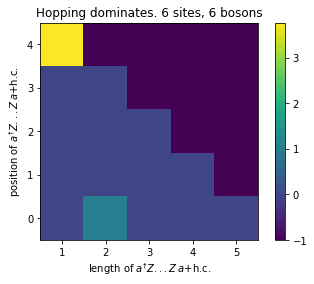

In [201]:
resRe=np.empty([Nsites,Nsites])
resRe.fill(-1)
resIm=np.empty([Nsites,Nsites])
for l in range(Nsites):
    for i in range(1,Nsites-l):
        hop=[1.0]
        for add in range(i):
            hop.append(l+add)
        hop.append(l)
        hop.append(l+i)
        static=[["z"*i+"|+-",[hop]],["z"*i+"|+-",[hop]]]
        no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
        correlator = hamiltonian(static,[],basis=basis,**no_checks).tocsr()
        correlator = P_sparse@correlator@P_sparse.T.conj()
        H_expt = np.dot(psi0.T.conj(),correlator@psi0)
        # print(H_expt[0,0],E)
        resRe[l][i]=np.real(H_expt[0,0])
        resIm[l][i]=np.imag(H_expt[0,0])

plt.imshow(resRe)#np.flip(resRe,0))
plt.colorbar()
plt.xlabel("length of $a^{\dagger}Z...Z\:a$+h.c.")
plt.ylabel("position of $a^{\dagger}Z...Z\:a$+h.c.")
plt.axis([0.5, 5.5, -0.5, 4.5])
plt.title("Hopping dominates. "+str(Nsites)+" sites, "+str(Nbosons)+" bosons")
plt.show()
# plt.imshow(np.flip(resIm,0))
# plt.colorbar()
# plt.show()

In [65]:
hop=[[1.0,0,0,1]]
#hop=[[1.0,i,i,i+1] for i in range(L_modes-1)]
static=[["z|+-",hop],["z|-+",hop]]
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
correlator = hamiltonian(static,[],basis=basis,**no_checks).tocsr()
correlator = P_sparse@correlator@P_sparse.T.conj()
H_expt = np.dot(psi0.T.conj(),correlator@psi0)
print(H_expt,E)

[[0.+0.j]] [-4.12997226]


##### Testing functions

In [97]:
for l in range(Nsites):
    for i in range(Nsites-l):
        hop=[1.0]
        for add in range(i):
            hop.append(l+add)
        hop.append(l)
        hop.append(l+i)
        print(hop)

[1.0, 0, 0]
[1.0, 0, 0, 1]
[1.0, 0, 1, 0, 2]
[1.0, 0, 1, 2, 0, 3]
[1.0, 1, 1]
[1.0, 1, 1, 2]
[1.0, 1, 2, 1, 3]
[1.0, 2, 2]
[1.0, 2, 2, 3]
[1.0, 3, 3]


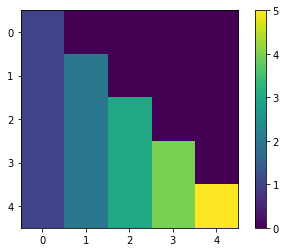

In [159]:
resli=np.zeros([Nsites,Nsites])
for l in range(Nsites):
    for i in range(Nsites-l):
        hop=[1.0]
        for add in range(i):
            hop.append(l+add)
        hop.append(l)
        hop.append(l+i)
        resli[l][i]=i

resli=np.delete(resli, 0, 1)

resli=np.delete(resli, -1, 0)

plt.imshow(np.flip(resli,0))
plt.colorbar()
plt.show()

### Density

In [31]:
density=[[1.0,3]]
static=[["|n",density]]
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
correlator = hamiltonian(static,[],basis=basis,**no_checks)
H_expt = correlator.expt_value(psi1,time=0,check=True)
print(H_expt)

(2.752281739308086+4.440892098500626e-16j)


In [29]:
obs_args={"basis":basis,"check_herm":False,"check_symm":False}
n=hamiltonian([["|n", [[1.0,0]] ]],[],dtype=np.float64,**obs_args)
Obs_t = obs_vs_time(psi1,t,{"n":n})
O_n = Obs_t["n"]
print(O_n)

(1.999961590738686-2.0194839173657902e-28j)


/tmp/ipykernel_5400/3460746893.py:2: UserWarning: Test for particle conservation not implemented for <class 'quspin.basis.tensor.tensor_basis'>, to turn off this warning set check_pcon=False in hamiltonian
  n=hamiltonian([["|n", [[1.0,0]] ]],[],dtype=np.float64,**obs_args)
